<h1 style='text-align:center'>Homework 4</h1>
<h2 style='text-align:center'>Author: Caleb Eades</h2>
<h2 style='text-align:center'>Due Date: March 5, 2018</h2>

<p>In this homework assignment, we get an approximation for pi using various methods of parallelization and compare the execution speeds of these different methods. The three methods are: serial (no parallelization), multiprocessing and ipyparallel.</p>

<h3>Serial</h3>
<p>For the serial code, I followed along with the example code given in the homework assignment, except that I split the evaluation into a dart throwing function that just returns the approximated value of pi, which I called <b><i>approx_pi_serial</i></b> and a wrapper for any function that runs it and returns the time it took to execute. This wrapper function is called <b><i>time_eval</i></b>. The docstrings should be pretty comprehensive in explaining how these functions work and how to use them.</p>

<h3>Multiprocessing</h3>
<p>For the multiprocessing code, instead of spawning individual processes myself and keeping track of them, I used the Pool class to handle this under the hood for me. You can specify the number of workers (which defaults to 4 as I have it set up) and then it will split up any pi approximation into smaller groups of darts to throw, evaluate them in parallel with the Pool, and then return and compile the results together into a final approximation for pi that it will return. This function is called <b><i>approx_pi_pool</i></b> and again it's docstring should be very useful. Note that for each of the workers in the pool that evaluates a smaller number of darts, that evaluation is sent to the <i>approx_pi_serial</i> function.</p>

<h3>Ipyparallel</h3>
<p>For the ipyparallel code, it effectively mimics the multiprocessing code except using IPcluster engines to create what I believe is called a view (based on the documentation I looked at) rather than a Pool. But they are both set up to use 4 "workers" as a default and therefore should have very similar behavior. Anyways, the function signature is <b><i>approx_pi_ipy</i></b> and it again splits the work up into smaller chunks for <i>approx_pi_serial</i> to evaluate before compiling into a final approximation for pi.</p>

<h3>Notes</h3>
<ul>
<li>I modified the <i>approx_pi_pool</i> and <i>approx_pi_ipy</i> functions to accept a pool and a view as arguments, respectively, after attempting to run my plot generator. Basically the problem I was running into was without killing a pool or view (which for some reason I couldn't get to work properly) each call to these functions created more processes or engines, which wound up killing my machine overall. So I now have it set up to just create one pool or view, respectively, to use for all the dart timings.</li>
<li>To actually run everything and create a plot, run <b>master_plot()</b> in a cell after the first two cells of code are evaluated.</li>
<li>I plot the execution time with one-sigma standard deviations above and below in a shaded region. The code currently doesn't do this for the rate of dart tossing as well, but the calculations are already there, so it would just be a minor change to the plotting commands to do so.</li>
<li>To change the number of darts to evaluate over (or rather the array of different dart values) to use in the Monte Carlo simulations in <b><i>master_plot</i></b>, go to the first line of code in the <b><i>make_plot_dict</i></b> function that says "DARTS=..." and change ... as appropriate.</li>
<li>I played around with the number of workers to use in Pool and the IPcluster, but 4 seems pretty optimal.</li>
<li>Running the <i>approx_pi_ipy</i> function <b>requires that an IPcluster is up and running</b>. It will also give a warning (something to do with ssh, but when I tried to follow it I got a failing error instead of just a warning). It will also print a couple of information lines saying which modules are being imported to the engines (based on the .view_sync() module imports in the code).</li>
<li>My machine is a Intel Core i5-4210U CPU @ 1.70GHz x 4</li>
</ul>

In [4]:
from random import uniform
from math import sqrt
from time import time
from multiprocessing import Pool
import ipyparallel as ipp

def time_eval(func,*args):
    """
    Wrapper to record and return the time it takes to evaluate
    a function it is given with certain arguments.
    
    :func: (function) the function to evaluate
    :*args: (arguments) the arguments to the function to be evaluated
    
    :returns: (float) the time it takes to execute func(*args)
    """
    start_time = time()
    func(*args)
    end_time = time()
    return end_time-start_time

def approx_pi_serial(num_darts):
    """
    Serial function to evaluate the approximation of pi.
    
    :num_darts: (int) the number of darts to use in the Monte Carlo simulation
    
    :returns: (float) the approximation of pi
    """
    in_circle = 0
    for i in range(num_darts):
        x,y = uniform(0,1),uniform(0,1) # throw a dart
        if sqrt((x-0.5)**2+(y-0.5)**2)<0.5:
            in_circle += 1 # if the dart is in the circle, note it
    return 4*in_circle/num_darts

def approx_pi_pool(num_darts,pool=None,workers=4):
    """
    Multiprocessing function to evaluate the approximation of pi. It
    will use the serial function approx_pi_serial but split the
    number of darts into workers bins.
    
    :num_darts: (int) the number of darts to use in the Monte Carlo simulation
    :pool: (multiprocessing.Pool object) the pool to use workers from
    :workers: (int) the number of workers (or cores) to use in the Pool class
    
    :returns: (float) the approximation of pi
    """
    # if the approx_pi_pool function if being run over multiple dart trials,
    # we don't want to create a new Pool of workers each time, so we reuse
    p = pool
    if p is None:
        p = Pool(workers)
        
    # create splits for number of darts for each worker to throw accordings to
    # how many workers there are
    splits = [num_darts//workers for i in range(workers-1)] # try to split evenly
    splits.append(int(num_darts - sum(splits))) # account for any remainder with uneven split
    
    # run the serial function for each of the splits in each of the workers
    results = p.map(approx_pi_serial,splits)
    # do a weighted sum over the workers which is basically an average but accounts for
    # the fact that the last worker could have more a few more darts thrown than the others
    results = [results[i]*splits[i]/num_darts for i in range(workers)]
    return sum(results)

def approx_pi_ipy(num_darts,view=None):
    """
    Ipyparallel function to evaluate the approximation of pi. It
    will use the serial function approx_pi_serial but split the
    number of darts into multiple bins (according to how many workers
    the ipyparallel client gives).
    
    This code is essentially the same as the approx_pi_pool function
    except using the Ipython cluster for the workers.
    
    :num_darts: (int) the number of darts to use in the Monte Carlo simulation
    :view: (ipyparallel.Client view object) the view to use workers from
    
    :returns: (float) the approximation of pi
    """
    # if the approx_pi_ipy function if being run over multiple dart trials,
    # we don't want to create a new view of workers each time, so we reuse
    v = view
    if view is None:
        c = ipp.Client()
        v = c[:]
        with v.sync_imports() as sync_ports:
            # import the modules needed to approximate pi (in the serial function)
            # and time it so that these modules are common to all engines in the view
            from random import uniform
            from math import sqrt
            from time import time
    # create splits for number of darts for each worker to throw accordings to
    # how many workers there are
    workers = len(v)
    splits = [num_darts//workers for i in range(workers-1)] # try to split evenly
    splits.append(int(num_darts-sum(splits))) # account for any remainder with uneven split
    
    # do a weighted sum over the workers which is basically an average but accounts for
    # the fact that the last worker could have more a few more darts thrown than the others
    results = v.map_sync(approx_pi_serial,splits)
    results = [results[i]*splits[i]/num_darts for i in range(workers)]
    return sum(results)

In [13]:
from numpy import std,copy,log10
import matplotlib.pyplot as plt

def make_plot_dict(func,multi_object=None,iterations_per_darts=10):
    """
    Makes a dictionary of arrays with useful keys for use with the final
    plot. It calculates and stores the execution time and one sigma below
    and above, along with the rate of darts being thrown (with one sigma
    below and above as well, but those aren't plotted at the moment in the
    final plot).
    
    :func: (function) the function to test the execution times of:
            approx_pi_serial, approx_pi_pool, or approx_pi_ipy
    :multi_object: (None, multiprocessing.Pool or ipyparallel view object)
                    the object to use in the pool or ipy approx_pi methods
                    as the holder of the workers (None if serial)
    :iterations_per_darts: (int) the number of trials to run the function
                            timing through at each dart test to create the
                            one sigma uncertainties
    
    :returns: (dict) dictionary of key:array pairs with the keys being
                convenient ones for plotting
    """
    # IMPORTANT: The following line is where you change the number of darts
    # to time the functions over.
    DARTS = [2**j for j in range(3,25)]
    
    plot_dict = {'x':[dart for dart in DARTS],'y':[],'y_low':[],'y_high':[]\
                ,'r':[],'r_low':[],'r_high':[]}
    for darts in plot_dict['x']:
        times = []
        rates = []
        for i in range(iterations_per_darts):
            if multi_object is not None:
                # pool or ipy evaluations
                times.append(time_eval(func,darts,multi_object))
            else:
                # serial evaluation
                times.append(time_eval(func,darts))
            rates.append(darts/times[-1])
        # calculate and store execution time with one sigma
        # below and above
        avg_t = sum(times)/iterations_per_darts
        sigma_t = std(times)
        plot_dict['y'].append(avg_t)
        plot_dict['y_low'].append(avg_t-sigma_t)
        plot_dict['y_high'].append(avg_t+sigma_t)
        # calculate and store rate of darts thrown with one
        # sigma below and above
        avg_r = sum(rates)/iterations_per_darts
        sigma_r = std(rates)
        plot_dict['r'].append(avg_r)
        plot_dict['r_low'].append(avg_r-sigma_r)
        plot_dict['r_high'].append(avg_r+sigma_r)
    return plot_dict

def master_plot():
    """
    Creates the plot that shows execution time and rate of darts thrown
    for the different parallelization methods.
    """
    # Handy reference dictionaries
    run_types = {'Serial':approx_pi_serial,'Multiprocessing':approx_pi_pool\
                ,'IPcluster':approx_pi_ipy}
    colors = {'Serial':'red','Multiprocessing':'green','IPcluster':'blue'}
    
    fig,ax = plt.subplots()
    axr = ax.twinx() # create a twin axis for the rates
    for key in run_types:
        if key=='Multiprocessing':
            # set up a pool of workers to be used across all dart timings
            p = Pool(4)
            data = make_plot_dict(run_types[key],p)
        elif key=='IPcluster':
            # set up a ipyparallel view to be used across all dart timings
            c = ipp.Client()
            v = c[:]
            with v.sync_imports() as syncing:
                # import the modules needed to approximate pi (in the serial function)
                # and time it so that these modules are common to all engines in the view
                from math import sqrt
                from random import uniform
                from time import time
            data = make_plot_dict(run_types[key],v)
        else:
            data = make_plot_dict(run_types[key])
        # plot the execution time and one sigma below and above with shading
        ax.plot(data['x'],data['y'],color=colors[key],label=key)
        ax.fill_between(data['x'],data['y_low'],data['y_high'],color=colors[key],alpha=0.5)
        
        # plot the rate of darts thrown (on the twinned axis)
        axr.plot(data['x'],data['r'],'--',color=colors[key])
    ax.loglog()
    axr.loglog()
    ax.legend(loc=4) # lower-left legend location
    ax.set_xlabel('Darts Thrown')
    ax.set_ylabel('Execution Time (s), solid lines (with one sigma shading)')
    axr.set_ylabel('Rate Thrown (darts/s)')
    ax.set_title('Comparing Methods of Estimating Pi as a Function of Darts Thrown')

/home/kceades/anaconda3/lib/python3.6/site-packages/ipyparallel/client/client.py:458: RuntimeWarning: 
            Controller appears to be listening on localhost, but not on this machine.
            If this is true, you should specify Client(...,sshserver='you@kceades-Inspiron-3542')
            or instruct your controller to listen on an external IP.
  RuntimeWarning)


importing sqrt from math on engine(s)
importing uniform from random on engine(s)
importing time from time on engine(s)


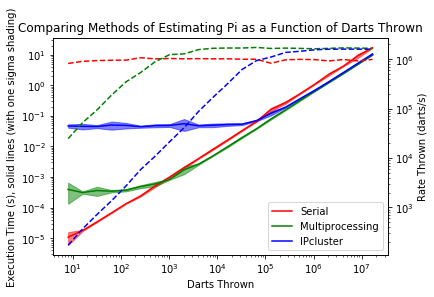

In [14]:
master_plot()